# MPModel: Infering the detergent corona around a membrane protein

Throughout this tutorial, we will buid a coarse-grained model of a micelle around the  membrane protein Aquaporin-0 (PDB: 2B6P [1]) and use the `simSPI` package to simulate a cryo-EM experiment of the structure. For that, it is necessary to have installed the TEM-simulator [2] and the python libraries: Matplotlib Numpy, Gemmi, Scikit-learn and Scipy.


<p align="center">
    <img src="figures/2b6p_map.png" alt="Drawing" style="width: 700px;"/>
    <p style="text-align: center">
        Figure 1: _Bos taurus_ Aquaporin-0 complex
    </p>
</p>

In [1]:
import os
import sys
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import math
import gemmi
import torch
import mrcfile
from matplotlib import pyplot as plt, axes as ax
from scipy.spatial.transform import Rotation as rot

from simSPI.linear_simulator.linear_simulator import LinearSimulator
from test_linear_simulator import init_data

import detergent_belt as mpm
import atomic_models

from torchmetrics.image import UniversalImageQualityIndex   

## Creating the model
### Extracting the protein atomic coordinates from a PDB file

<p align="center">
    <img src="figures/aquaporin.png" alt="Drawing" style="width: 400px;"/>
    <p style="text-align: center">
        Figure 2: Representation of the atomic coordinates of aquaporin
    </p>
</p>

### Centering and rotating the structure
<p style='text-align: justify;margin-right:10%;'>
Using Principal Component Analysis (PCA), a method for data decomposition, we can extract the main axis where our data is distributed. We can use a matrix transformation as a function to represent a modification on our dataset. In this case, the transformation is aligning the principal component of the coordinate points to the Z-axis. Therefore, we can distribute the atoms on another axis and, by doing so, rotate the protein so that its transmembrane portion is positioned properly in space.
</p>

<p align="center">
    <img src="figures/aquaporin_rotated.png" alt="Drawing" style="width: 400px;"/>
    <p style="text-align: center">
        Figure 3: Aquaporin structure rotated and centered at the origin
    </p>
</p>

### Creating a corona around the protein

To create the Ellipsoid we will compute the points that satisfy the condition: 
$\frac{x^{2}}{a^{2}} + \frac{y^{2}}{b^{2}} + \frac{z^{2}}{c^{2}} >= 1$

Consider $O = (0,0,0)$, as the protein was centered after the coordinates were imported.

<p align="center">
    <img src="figures/ellipsoid.png" alt="Drawing" style="width: 200px;"/>
    <p style="text-align: center">
        Figure 4: The geometric parameters of an ellipsoid
    </p>
</p>

The method used in this program creates an ellipsoid by generating points iteratively in regular intervals dependent on the ray of the pseudoatom. After that, a function removes the coordinates in the most inner part of the ellipsoid that would conflict with the protein's atoms. This process' speed depends on the number of pseudo atoms, that itself depends on the parameters of the corona such as the height, determined by size of the transmembrane portion of the protein, and on the ray of the pseudo atoms filling the ellipsoid.

### Excluding the overlaping pseudoatoms
Now that we have our two ellipsoids we need to delete from our corona the pseudo atoms that are physically overlapping with other atoms

### Generating the final PDB file

<p align="center">
    <img src="figures/aqp_model_abc.png" alt="Drawing" style="width: 600px;"/>
    <p style="text-align: center">
        Figure 5: Model of detergent micelle and membrane protein Aquaporin (AQP0) seen as A- full model, B- micelle
hydrophobic core and C- frontal cut. The micelle hydrophobic core is represented in yellow,
the hydrophilic shell in blue and the protein in pink.
    </p>
</p>

XXXXXXXXXXXXX CHIMERAX XXXXXXXXXXXXX molmap #[structure] [res]

ADD STEPS
ADD IMAGE
MAYBE AUTOMIZE

In [5]:
def set_protein(path, ptn_axis):
    ptn = mpm.MembraneProtein(path)
    ptn.rotate_protein(ptn_axis)
    return ptn
        
def build_model(sample,ptn):
    micelle = mpm.DetergentBelt()
    micelle.set_belt_parameters(sample,40,25,7,[0,0,0]) #a1,a2,h,t,cset the parameters for the core of your micelle
    micelle.set_atomic_parameters(1.5, "C", "N")  #set the parameters for hydrophobic and hydrophilic pseudoatoms
    micelle.generate_core()
    micelle.generate_shell()

    micelle.in_hull(micelle.core_coordinates_set,ptn.final_coordinates)
    micelle.remove(micelle.core_coordinates_set)

    micelle.in_hull(micelle.shell_coordinates_set,micelle.core_coordinates_set)
    micelle.remove(micelle.shell_coordinates_set)
    micelle.in_hull(micelle.shell_coordinates_set,ptn.final_coordinates)      
    micelle.remove(micelle.shell_coordinates_set)

    file_name = f"outputs/pdb/7wsn/experiment_3/{sample}.pdb"   #name your pdb file
    M = mpm.Model()
    M.clean_gemmi_structure()
    M.write_atomic_model(file_name, model=gemmi.Model("model"))
    M.create_model(file_name,micelle,ptn)

## Linear Simulation

In [6]:
def rotation(N):
    A = np.random.uniform(0,2*np.pi,N)
    V = np.random.uniform(0,1,3)
    R = []
    for a in A:
        r = rot.from_rotvec(a*V)
        R.append(r.as_matrix())
    return R #sampled rotations

def LinSim(vol_path, data_path, rotations):
    '''
    rotations -> list of rotation matrices
    '''
    with mrcfile.open(vol_path) as file:
        vol = file.data
    saved_data, config = init_data(data_path)
    
    #nx = vol.shape[0]
    nx = 200
    config["input_volume_path"] = vol_path
    config["side_len"] = nx
    config["ctf_size"] = nx
    config["pixel_size"] = 1.2
    
    config["noise"] = True
    config["noise_sigma"] = 0.5

    lin_sim = LinearSimulator(config)
    
    N = len(rotations)
    
    ctf_params = saved_data["ctf_params"]
    shift_params = saved_data["shift_params"]
    rot_params = {'rotmat': torch.Tensor(rotations)}
    
    #ctf_params["defocus_u"] = torch.tensor([1.1000,2.1000,1.5000,1.7000,1.1000,2.1000,1.5000,1.7000]).reshape(N,1,1,1)
    #ctf_params["defocus_v"] = torch.tensor([1.0000,2.2000,1.6000,1.8000,1.10000,2.2000,1.6000,1.8000]).reshape(N,1,1,1)
    #ctf_params["defocus_angle"] = torch.tensor([0.3142,1.5708,2.5133,3.1416,0.3142,1.5708,2.5133,3.1416]).reshape(N,1,1,1)
    #shift_params["shift_x"] = torch.tensor([0.0,0.0,0.0,0.0])
    #shift_params["shift_y"] = torch.tensor([0.0,0.0,0.0,0.0])

    particles = lin_sim(rot_params, ctf_params, shift_params)
    
    return particles #torch tensor for particle projection

## Parameter Inference

<p align="center">
    <img src="figures/parameters_new.png" alt="Drawing" style="width: 450px;"/>
    <p style="text-align: center">
        Figure 6: XXXXXXXXXXXXXXXXXXXXXXX ADD DESCRIPTION AND REFERENCE XXXXXXXXXXXXXXXXXXXX
    </p>
</p>

We will infer the parameter "a" by Rejection Approximation Bayesian Computation.

In [76]:
def run_sampling(runs,ptn,span):
    for i in range(runs):
        a = np.random.uniform(span[0],span[1])   #sample parameter a
        model = build_model(a,ptn)  #create model using sampled a
        print(a)

def pdb_to_mrc():
    pass
    
def run_projection(): 
    proj1 = LinSim(vol_path, data_path, R1)
    torch.save(proj1, proj_path)

def psnr(proj1, proj2):
    p1 = torch.max(proj1)
    p2 = torch.max(proj2)
    if p1 >= p2:
        p = p1
    else:
        p = p2
    se = []
    for i in range(len(proj1)):
        se.append(torch.sum((proj1[i]-proj2[i])**2))
    mse = np.mean(se)
    psnr = (10*(np.log10(p)**2))/mse
    return psnr

def rmsd(proj1, proj2):
    sd = []
    for i in range(len(proj1)):
        sd.append(torch.sum((proj1[i]-proj2[i])**2))
    return np.mean(np.sqrt(sd))
        
def run_inference(folder,gt):
    dataset = dict()
    for filename in os.scandir(folder):
        sim_proj = torch.load(filename.path)
        distance = psnr(gt_proj, sim_proj)
        dataset[str(filename).strip("'<DirEntry .npy>'")] = distance
    rank = sorted(dataset.items(), key=lambda x:x[1])
    return rank

In [9]:
ptn = set_protein("7wsn.pdb", "Z")
runs = 20
span = [35,90]

print(run_sampling(runs,ptn,span))
#print(torch.load())

39.06571181934269
37.971272273267694
75.2981683512479
59.50473958798367
68.89850432250329
77.30250782352093
85.36918913753394
69.24624740120377
63.46075086933429
49.77331341633746
86.95213845797477
89.80680188039753
62.35554420233018
73.18361478489955
59.84592932991188
39.09961717494501
62.82977161889205
78.49715729255557
50.622622718443985
79.4417116300329
None


In [10]:
build_model(50,ptn)

In [7]:
root_dir = "/home/halv/"  # change this to your simSPI directory.
gt_file = "gt"
gt_model = f"{root_dir}compSPI_fork/simSPI/notebooks/outputs/mrc/7wsn/{gt_file}.mrc"
data_path = f"{root_dir}compSPI_fork/simSPI/tests/data/linear_simulator_data.npy"
proj_folder = f"{root_dir}compSPI_fork/simSPI/notebooks/outputs/projections/7wsn/experiment_3"

In [8]:
rot = [[[ 0.71776143,  0.52648782, -0.45566337],
       [ 0.02935378,  0.63095527,  0.7752637 ],
       [ 0.6956701 , -0.56982982,  0.43742095]], [[ 0.09148036,  0.81331589,  0.57458559],
       [ 0.97592573, -0.1879467 ,  0.11065714],
       [ 0.19799068,  0.55062991, -0.81092934]], [[ 0.5965571 ,  0.66521582, -0.44900729],
       [ 0.12932599,  0.47247297,  0.87180507],
       [ 0.79208233, -0.57814982,  0.19582741]], [[ 0.42557599,  0.82837522, -0.36425207],
       [ 0.30289736,  0.24890439,  0.91994554],
       [ 0.85272403, -0.50183772, -0.14498494]], [[ 0.43528531,  0.82011672, -0.37139636],
       [ 0.29203428,  0.26159994,  0.91993557],
       [ 0.85161181, -0.50889491, -0.12563159]], [[ 0.17689998,  0.98298448, -0.04947645],
       [ 0.63803148, -0.07625517,  0.76622515],
       [ 0.74941459, -0.16711275, -0.64066458]], [[ 0.71942651,  0.02813017,  0.6939987 ],
       [ 0.52443221,  0.63313247, -0.56931023],
       [-0.4554079 ,  0.77353214,  0.44073991]], [[ 0.45444147,  0.80345366, -0.38463641],
       [ 0.27097115,  0.28664782,  0.91891657],
       [ 0.84856207, -0.52181916, -0.08744811]]]

In [4]:
R1 = [[[ 0.1839408 , -0.35855848,  0.91520577],
       [ 0.46419033,  0.85241333,  0.24066335],
       [-0.86642549,  0.38056186,  0.32323297]],
       
       [[ 0.7806223 , -0.24775242,  0.57380098],
       [ 0.27614898,  0.96032491,  0.0389591 ],
       [-0.56068758,  0.12804221,  0.81806762]],
       
       [[-0.1475522 , -0.3389701 ,  0.92915425],
       [ 0.48751086,  0.79246187,  0.3665206 ],
       [-0.86055883,  0.50705371,  0.04832211]],
       
       [[-0.85591971,  0.32969827, -0.39837231],
       [-0.08946541,  0.66435155,  0.74204646],
       [ 0.5093107 ,  0.67077274, -0.539135  ]]]
       
R2 = [[[ 0.53679316, -0.30666962,  0.7860069 ],
       [ 0.83176915,  0.03614443, -0.55394373],
       [ 0.14146794,  0.9511295 ,  0.27448041]],
       
       [[ 0.59263101,  0.80096743,  0.08508622],
       [-0.33916667,  0.1523336 ,  0.92831053],
       [ 0.73058501, -0.57900401,  0.36193908]], 
       
       [[ 0.6352191 , -0.35745285,  0.68463432],
       [ 0.77097499,  0.24095226, -0.58952487],
       [ 0.04576316,  0.9023134 ,  0.42864469]],
       
       [[ 0.96869486, -0.19600425,  0.15235681],
       [ 0.23149231,  0.93485927, -0.26916436],
       [-0.08967482,  0.29600756,  0.95096685]]]
       
R3 = [[[ 0.85802171, -0.34406771,  0.38133471],
       [ 0.36523444,  0.93074178,  0.01798711],
       [-0.36111293,  0.12384323,  0.92426203]],
       
       [[-0.59572283, -0.42411887,  0.6820832 ],
       [ 0.6620161 ,  0.22159284,  0.71598275],
       [-0.45480655,  0.87807733,  0.14876561]],
       
       [[-0.77651325, -0.28404581,  0.56244569],
       [ 0.54889605,  0.13340174,  0.82517701],
       [-0.3094193 ,  0.9494851 ,  0.05232341]],
       
       [[-0.9293552 , -0.07103292,  0.36228888],
       [ 0.3586695 ,  0.05884413,  0.93160805],
       [-0.08749341,  0.99573676, -0.02920976]]]

R4 = [[[-0.1643302 ,  0.41784442,  0.89353323],
       [ 0.93996884, -0.20832921,  0.27029153],
       [ 0.29908888,  0.88431046, -0.35852595]],
       
       [[ 0.29106097, -0.10313157,  0.95112953],
       [ 0.92987885,  0.26427079, -0.25590287],
       [-0.22496409,  0.95891857,  0.17281878]],
       
       [[-0.24449334,  0.78249715,  0.57264406],
       [ 0.6688004 , -0.29152164,  0.68390143],
       [ 0.70208905,  0.55019392, -0.4520593 ]],
       
       [[ 0.77837569, -0.26922203,  0.56714265],
       [ 0.52767485,  0.7700007 , -0.35868952],
       [-0.34013312,  0.57846212,  0.74141152]]]

R5 = [[[-0.75294892,  0.54348553, -0.37106793],
       [ 0.37632785,  0.81817005,  0.43471268],
       [ 0.53985672,  0.18767324, -0.82056899]],
       
       [[ 0.27835729,  0.01949236,  0.96027979],
       [ 0.35917048,  0.92514542, -0.1228923 ],
       [-0.89079391,  0.37911212,  0.25051989]],
      
      [[ 0.14523074,  0.05048909,  0.98810874],
       [ 0.39802837,  0.91133646, -0.10506789],
       [-0.90580431,  0.4085544 ,  0.11225798]],
      
      [[-0.83779085,  0.43877559,  0.32493457],
       [ 0.52555633,  0.80936957,  0.26212869],
       [-0.14797648,  0.39038043, -0.90868371]]]

In [13]:
gt_model = f"{root_dir}compSPI_fork/simSPI/notebooks/outputs/mrc/7wsn/experiment_3/gt.mrc"
gt_proj = LinSim(gt_model, data_path, rot) #simulate image with ground truth model
torch.save(gt_proj, proj_folder+"/gt.npy")

TypeError: object of type 'type' has no len()

In [15]:
gt_model = f"{root_dir}compSPI_fork/simSPI/notebooks/outputs/mrc/7wsn/experiment_3/gt.mrc"
proj1 = LinSim(gt_model, data_path, R1)
proj2 = LinSim(gt_model, data_path, R2)
proj3 = LinSim(gt_model, data_path, R3)
proj4 = LinSim(gt_model, data_path, R4)
proj5 = LinSim(gt_model, data_path, R5)

proj = torch.cat((proj1,proj2,proj3,proj4,proj5),0)
torch.save(proj, proj_folder+"/gt.npy")

In [73]:
sample = "59.846"
root_dir = "/home/halv/"  # change this to your simSPI directory.
vol_path = f"{root_dir}compSPI_fork/simSPI/notebooks/outputs/mrc/7wsn/experiment_3/{sample}.mrc"
data_path = f"{root_dir}compSPI_fork/simSPI/tests/data/linear_simulator_data.npy"
proj_path = f"{root_dir}compSPI_fork/simSPI/notebooks/outputs/projections/7wsn/experiment_3/{sample}.npy"

In [74]:
proj1 = LinSim(vol_path, data_path, R1)
proj2 = LinSim(vol_path, data_path, R2)
proj3 = LinSim(vol_path, data_path, R3)
proj4 = LinSim(vol_path, data_path, R4)
proj5 = LinSim(vol_path, data_path, R5)

proj= torch.cat((proj1,proj2,proj3,proj4,proj5),0)
torch.save(proj, proj_path)
#print(torch.load(proj_path).shape,torch.load(proj_path))

In [88]:
gt_proj = torch.load(f"{root_dir}compSPI_fork/simSPI/notebooks/outputs/projections/7wsn/experiment_3/gt.npy")
a = run_inference(proj_folder,gt_proj)

for i in a:
    print(float(i[0]),i[1].numpy())
    #print(float(i[0]),i[1])

89.807 9.70073e-05
86.952 9.845675e-05
85.369 9.9160425e-05
79.442 0.00010477086
78.497 0.00010809824
77.302 0.00011217937
75.298 0.000116241325
73.184 0.00011990959
69.246 0.00013679403
68.898 0.00013780464
37.971 0.00014048401
39.066 0.000142731
39.099 0.00014295803
63.461 0.00017454344
62.829 0.00017801997
62.355 0.00018223816
59.846 0.00021543092
59.505 0.00021905062
49.773 0.00040188187
50.623 0.00040288322


ValueError: could not convert string to float: 'g'

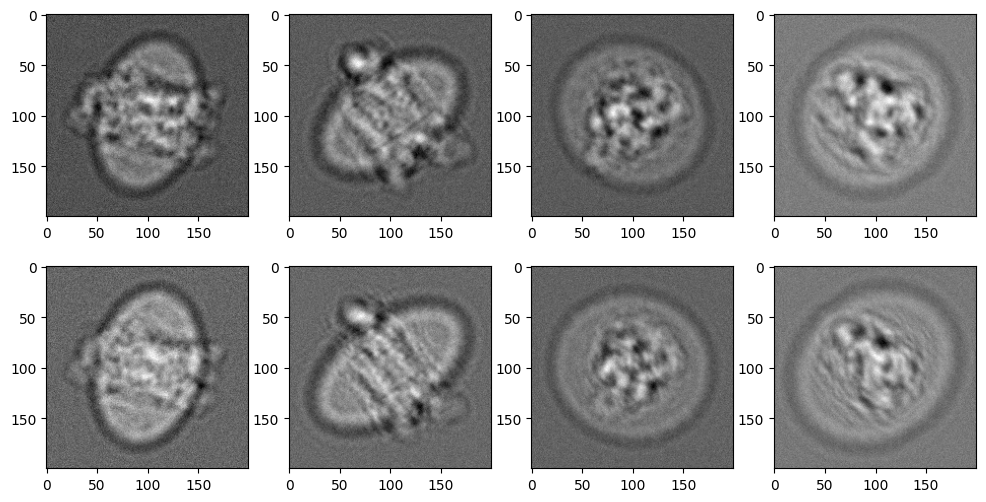

In [10]:
proj1 = torch.load(f"{root_dir}compSPI_fork/simSPI/notebooks/outputs/projections/7wsn/experiment_3/gt.npy")
proj2 = torch.load(f"{root_dir}compSPI_fork/simSPI/notebooks/outputs/projections/7wsn/experiment_3/77.302.npy")
#proj3 = torch.load(f"{root_dir}compSPI_fork/simSPI/notebooks/outputs/projections/7wsn/experiment_3/7wsn_abc_36.193432428890794.npy")

f, ax = plt.subplots(2, 4, figsize=(12, 6))

ax[0,0].imshow(proj1[0, 0],cmap='gray')
ax[0,1].imshow(proj1[10, 0],cmap='gray')
ax[0,2].imshow(proj1[16, 0],cmap='gray')
ax[0,3].imshow(proj1[19, 0],cmap='gray')
ax[1,0].imshow(proj2[0, 0],cmap='gray')
ax[1,1].imshow(proj2[10, 0],cmap='gray')
ax[1,2].imshow(proj2[16, 0],cmap='gray')
ax[1,3].imshow(proj2[19, 0],cmap='gray')

In [ ]:
def project(data_path, R, mrc_folder, proj_folder):
    test = 0
    for file in os.scandir(mrc_folder):
        filename = str(file).strip("'<DirEntry >'")
        proj1 = LinSim(f"{mrc_folder}/{filename}", data_path, R1)
        proj2 = LinSim(f"{mrc_folder}/{filename}", data_path, R2)
        proj3 = LinSim(f"{mrc_folder}/{filename}", data_path, R3)
        proj4 = LinSim(f"{mrc_folder}/{filename}", data_path, R4)
        proj5 = LinSim(f"{mrc_folder}/{filename}", data_path, R5)

        proj = torch.cat((proj1,proj2,proj3,proj4,proj5),0)
        filename = filename.strip(".mrc")
        proj_path = f"{proj_folder}/{filename}.npy"
        torch.save(proj, proj_path)
        test += 1
        if test == 5: break

In [ ]:
project(data_path, R, mrc_folder, proj_folder)